##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

***

This code was modified by Prof. Elizabeth Barnes [CSU] for ATS 780A7 Spring 2022 at Colorado State University

[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_ml_ats/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/autoencoder_tensorflow.ipynb)

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [4]:

latent_dim = 64                                         # MODIFY: how many coding units to use (at the bottleneck)

#=================================================================================================================

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(784, activation='sigmoid'),
          layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim) 

2022-04-20 07:03:45.424780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0239 - val_loss: 0.0131
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.008

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

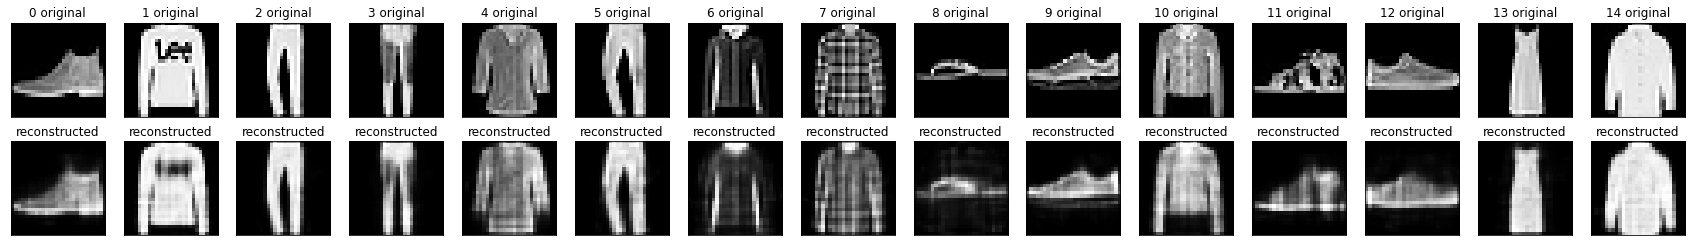

In [8]:
n = 15
plt.figure(figsize=(n*2, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title(str(i) + " original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Explore the latent space

In [9]:
print(encoded_imgs.shape)

(10000, 64)


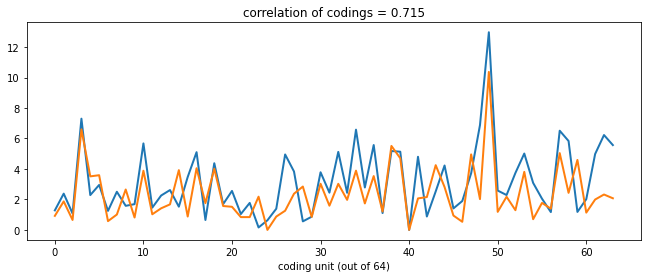

In [10]:
samples = (2,3)   # MODIFY: which two samples to compare

plt.figure(figsize=(11,4))
plt.plot(encoded_imgs[samples[0]],linewidth=2,)
plt.plot(encoded_imgs[samples[1]],linewidth=2,)
plt.xlabel('coding unit (out of ' + str(latent_dim) + ')')
plt.title('correlation of codings = ' + str(np.corrcoef(encoded_imgs[samples[0]],encoded_imgs[samples[1]])[0,1].round(3)))

plt.show()

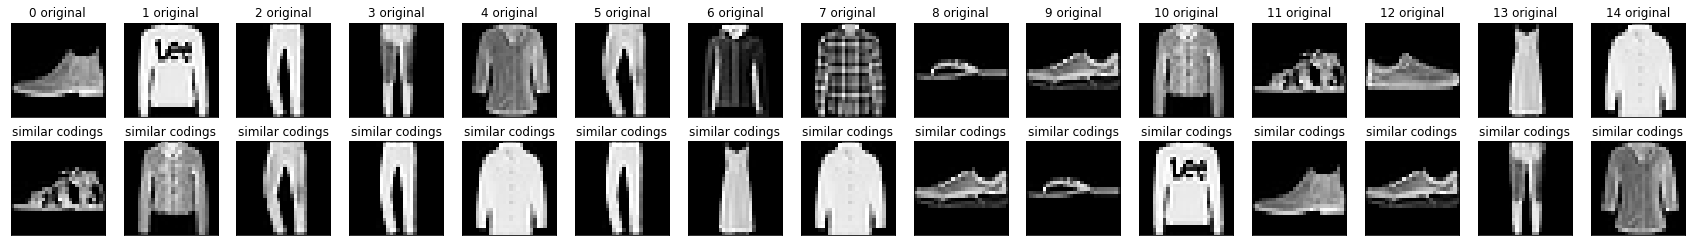

In [11]:
n_look = 15  # look for similar codings over the first 100 images

plt.figure(figsize=(n*2, 4))
for j in range(n):
    # display original
    ax = plt.subplot(2, n, j + 1)
    plt.imshow(x_test[j])
    plt.title(str(j) + " original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    c = 0.
    iplot = 0
    for i in range(n_look):      
        if i == j:
            continue
        c_new = np.abs(np.corrcoef(encoded_imgs[j,:],encoded_imgs[i,:]))[1,0]
        if c_new >= c:
            c = c_new
            iplot = i
        
    # display image that has the most similar coding
    if latent_dim > 2:
        ax = plt.subplot(2, n, j + 1 + n)
        plt.imshow(x_test[iplot])
        plt.title("similar codings")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    
plt.show()    

/Users/eabarnes/opt/anaconda3/envs/env-noah/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eabarnes/opt/anaconda3/envs/env-noah/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


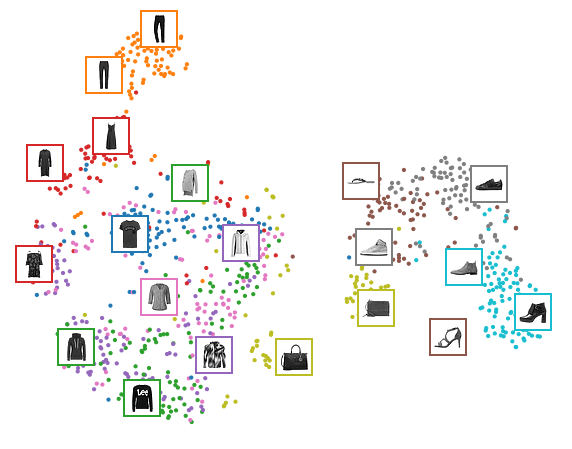

In [12]:
n_samples = 1_000

np.random.seed(42)
from sklearn.manifold import TSNE
import matplotlib as mpl

tsne = TSNE()
tsne_fits = tsne.fit_transform(encoded_imgs[:n_samples,:])
tsne_fits = (tsne_fits - tsne_fits.min()) / (tsne_fits.max() - tsne_fits.min())

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
# adapted from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(tsne_fits[:, 0], tsne_fits[:, 1], c=y_test[:n_samples], s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_fits):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[:n_samples][index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[:n_samples][index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [13]:
error('here')

NameError: name 'error' is not defined

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

2022-04-20 07:11:12.676929: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

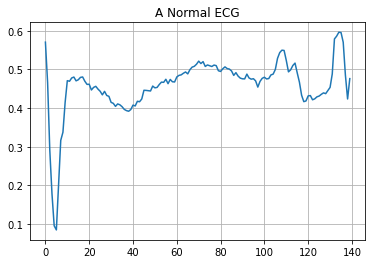

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

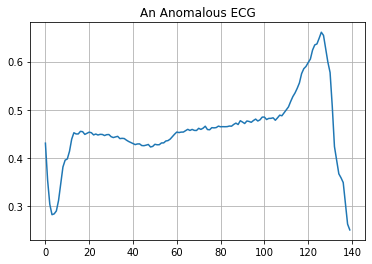

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [8]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Dense(32, activation="relu"),
          layers.Dense(16, activation="relu"),
          layers.Dense(8, activation="relu")])          # MODIFY: size of encoded latent space

        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [10]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=400, 
          batch_size=512,
          # validation_data=(test_data, test_data),              # this was in the TF version, but makes no sense to me if early stopping is used [EAB]
          validation_data=(normal_test_data, normal_test_data),  
          verbose = 0,
          shuffle=True)

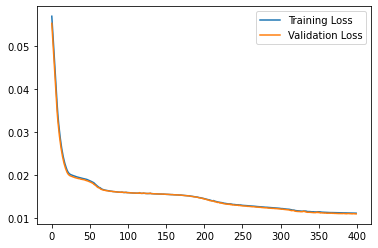

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

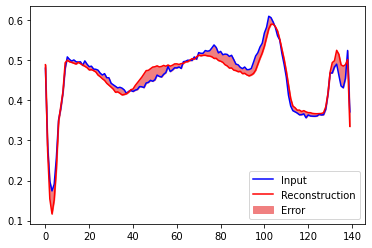

In [12]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

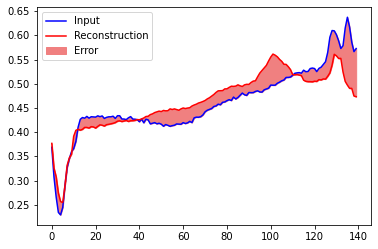

In [13]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

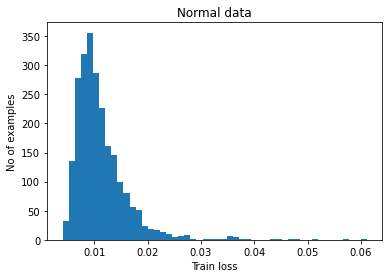

In [14]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.title('Normal data')
plt.show()

Choose a threshold value that is one standard deviations above the mean.

Threshold:  0.02421140600927174


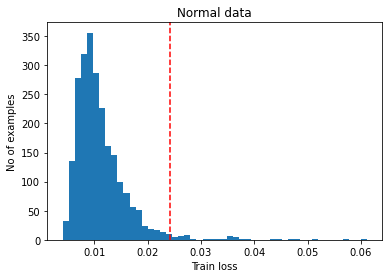

In [21]:
threshold = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold: ", threshold)

plt.hist(train_loss[None,:], bins=50)
plt.axvline(x=threshold, linestyle='--', color='r')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.title('Normal data')
plt.show()

Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

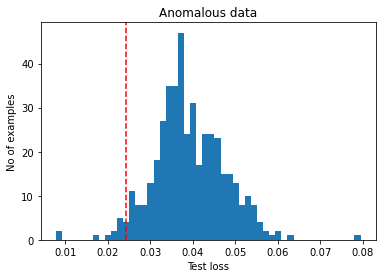

In [22]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.axvline(x=threshold, linestyle='--', color='r')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.title('Anomalous data')
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [23]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [24]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.976
Precision = 0.9768683274021353
Recall = 0.9803571428571428
